In [1]:
#!pip install neuralforecast

In [2]:
import pandas as pd

In [32]:
data = pd.read_excel("C:/Users/Usuario/Documents/Projectes/ChallengeAuditoria/challenge-auditoria/data/inventory_data_month.xlsx")


ts = ['Jan_2022', "Feb_2022", "Mar_2022", "Apr_2022", "May_2022", "Jun_2022", "Jul_2022", "Aug_2022", "Sep_2022", "Oct_2022", "Nov_2022", "Dec_2022", 'Jan_2023', "Feb_2023", "Mar_2023", "Apr_2023", "May_2023", "Jun_2023", "Jul_2023", "Aug_2023", "Sep_2023", "Oct_2023", "Nov_2023", "Dec_2023"]
data.fillna(0, inplace=True)
print(data.columns)
ts.extend(["material", "vendes_2022", "vendes_2023"])
data = data[ts]

Index(['Unnamed: 0.1', 'Unnamed: 0', 'material', 'unitats_2022', 'vendes_2022',
       'preu_venda_unitari_2022', 'unitats_2023', 'vendes_2023',
       'preu_venda_unitari_2023', 'variacio_preu_venda_unitari_2022_2023',
       'proporcio_variacio_preu_venda_unitari_2022_2023',
       'data_darrera_entrada', 'dies_ultima_entrada', 'data_darrera_sortida',
       'dies_ultima_sortida', 'diferencia_entrada_sortida', 'stock_final_2023',
       'valor_total_stock_2023', 'cost_unitari_stock_2023', 'Jan_2022',
       'Jan_2023', 'Feb_2022', 'Feb_2023', 'Mar_2022', 'Mar_2023', 'Apr_2022',
       'Apr_2023', 'May_2022', 'May_2023', 'Jun_2022', 'Jun_2023', 'Jul_2022',
       'Jul_2023', 'Aug_2022', 'Aug_2023', 'Sep_2022', 'Sep_2023', 'Oct_2022',
       'Oct_2023', 'Nov_2022', 'Nov_2023', 'Dec_2022', 'Dec_2023'],
      dtype='object')


C:\Users\Usuario\AppData\Local\Temp\ipykernel_10416\649198885.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  data.fillna(0, inplace=True)


In [33]:
df = pd.DataFrame(data)

# Unpivot the DataFrame
df = df.melt(id_vars=["material", "vendes_2022", "vendes_2023"], var_name='ds', value_name='y')

# Extract year and month from 'ds' column
df['ds'] = pd.to_datetime(df['ds'], format='%b_%Y')

# Rename the 'material' column to 'unique_id'
df.rename(columns={'material': 'unique_id'}, inplace=True)

print(df)

      unique_id  vendes_2022  vendes_2023         ds             y
0     114230822     54892.49     58951.87 2022-01-01   1002.876978
1     115030252      6825.62      2127.68 2022-01-01     56.596995
2     115070602    100307.84     34522.45 2022-01-01   6079.577671
3     115130209      5179.48      3770.68 2022-01-01    259.045453
4     115170581     26188.50     74195.50 2022-01-01   1180.711925
...         ...          ...          ...        ...           ...
9187  182080257     27030.19     17886.40 2023-12-01   1257.852506
9188  182080258      3945.01         0.00 2023-12-01      0.000000
9189  182080259    112860.80    326272.67 2023-12-01  26980.031073
9190  182080260      8513.28     11016.96 2023-12-01      0.000000
9191  182130161    457202.60    390388.11 2023-12-01  43500.579629

[9192 rows x 5 columns]


In [34]:
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM, NHITS, RNN, NBEATS, TimesNet, FEDformer

nf = NeuralForecast(
    models = [NBEATS(input_size=12, h=13, max_steps=100, hist_exog_list = ["vendes_2022", "vendes_2023"]),
              TimesNet(input_size=12, h=13, max_steps=100),
              FEDformer(input_size=12, h=13, max_steps=100)
              ],
    freq = 'M'
)

nf.fit(df=df)
new_df = nf.predict()

c:\Users\Usuario\Documents\Projectes\ChallengeAuditoria\challenge-auditoria\.venv\Lib\site-packages\pytorch_lightning\utilities\parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
Seed set to 1
Seed set to 1
Seed set to 1
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 2.4 M 
-----------------------------------------------
2.4 M     Trainable params
675       Non-trainable params
2.4 M     Total params
9.700     Total estimated model params size (MB)


c:\Users\Usuario\Documents\Projectes\ChallengeAuditoria\challenge-auditoria\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\Usuario\Documents\Projectes\ChallengeAuditoria\challenge-auditoria\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\Usuario\Documents\Projectes\ChallengeAuditoria\challenge-auditoria\.venv\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n

Epoch 8:  33%|███▎      | 4/12 [00:00<00:00, 13.27it/s, v_num=34, train_loss_step=7.51e+3, train_loss_epoch=7e+3]    

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 8:  33%|███▎      | 4/12 [00:00<00:00, 13.21it/s, v_num=34, train_loss_step=7.51e+3, train_loss_epoch=7e+3]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



  | Name           | Type          | Params
-------------------------------------------------
0 | loss           | MAE           | 0     
1 | padder_train   | ConstantPad1d | 0     
2 | scaler         | TemporalNorm  | 0     
3 | model          | ModuleList    | 4.7 M 
4 | enc_embedding  | DataEmbedding | 192   
5 | layer_norm     | LayerNorm     | 128   
6 | predict_linear | Linear        | 325   
7 | projection     | Linear        | 65    
-------------------------------------------------
4.7 M     Trainable params
0         Non-trainable params
4.7 M     Total params
18.752    Total estimated model params size (MB)


Epoch 8:  33%|███▎      | 4/12 [00:07<00:14,  0.56it/s, v_num=35, train_loss_step=18.10, train_loss_epoch=230.0]  

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 8:  33%|███▎      | 4/12 [00:07<00:14,  0.56it/s, v_num=35, train_loss_step=18.10, train_loss_epoch=230.0]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type          | Params
------------------------------------------------
0 | loss          | MAE           | 0     
1 | padder_train  | ConstantPad1d | 0     
2 | scaler        | TemporalNorm  | 0     
3 | decomp        | SeriesDecomp  | 0     
4 | enc_embedding | DataEmbedding | 384   
5 | dec_embedding | DataEmbedding | 384   
6 | encoder       | Encoder       | 161 K 
7 | decoder       | Decoder       | 177 K 
------------------------------------------------
339 K     Trainable params
0         Non-trainable params
339 K     Total params
1.359     Total estimated model params size (MB)



Epoch 8:  33%|███▎      | 4/12 [00:04<00:08,  1.00it/s, v_num=36, train_loss_step=7.48e+3, train_loss_epoch=6e+3]    

`Trainer.fit` stopped: `max_steps=100` reached.


Epoch 8:  33%|███▎      | 4/12 [00:04<00:08,  1.00it/s, v_num=36, train_loss_step=7.48e+3, train_loss_epoch=6e+3]

c:\Users\Usuario\Documents\Projectes\ChallengeAuditoria\challenge-auditoria\.venv\Lib\site-packages\utilsforecast\processing.py:362: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\Usuario\Documents\Projectes\ChallengeAuditoria\challenge-auditoria\.venv\Lib\site-packages\utilsforecast\processing.py:414: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
c:\Users\Usuario\Documents\Projectes\ChallengeAuditoria\challenge-auditoria\.venv\Lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
GPU available: False, used: False
TPU available: Fal


Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 119.46it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 12/12 [00:05<00:00,  2.28it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|██████████| 12/12 [00:00<00:00, 33.38it/s]


c:\Users\Usuario\Documents\Projectes\ChallengeAuditoria\challenge-auditoria\.venv\Lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [35]:
new_df.head()

,ds,NBEATS,TimesNet,FEDformer
unique_id,,,,
114230822,2023-12-31,5680.499023,5461.517090,4462.982422
114230822,2024-01-31,5675.705566,6590.655273,4438.427734
114230822,2024-02-29,4982.988281,6975.694336,4414.022461
114230822,2024-03-31,6963.269531,8095.008789,4389.803711
114230822,2024-04-30,6620.392578,6371.298828,4365.262695


In [36]:
def save_result(new_df, name):
    df = pd.DataFrame(new_df)

    # Convert 'ds' column to datetime
    df['ds'] = pd.to_datetime(df['ds'])

    # Pivot the DataFrame
    df_pivot = df.pivot_table(index='unique_id', columns='ds', values=f'{name}', aggfunc='first')

    # Reset index to make 'unique_id' a column again
    df_pivot.reset_index(inplace=True)

    # Rename columns
    df_pivot.columns.name = None  # Remove the name of the columns index
    df_pivot.columns = ['unique_id'] + [col.strftime('%b_%Y') for col in df_pivot.columns[1:]]

    print(df_pivot)

    df_pivot = df_pivot.drop(["Dec_2023"], axis=1)
    forecasts = df_pivot.set_index('unique_id').T.to_dict(orient='list')
    import json
    new_forecasts = {key: list(value) for key, value in forecasts.items()}
    # Saving the dictionary to a JSON file
    with open(f"../forecast/{name}.json", "w") as json_file:
        json.dump(new_forecasts, json_file)

    return df_pivot

times_net_df =save_result(new_df, 'TimesNet')
save_result(new_df, 'NBEATS')
save_result(new_df, 'FEDformer')

     unique_id      Dec_2023      Jan_2024      Feb_2024      Mar_2024  \
0    114230822   5461.517090   6590.655273   6975.694336   8095.008789   
1    115030252     39.356415     82.032761     53.134689     30.549194   
2    115070602   -119.502197    121.265869    -19.376953   -892.581055   
3    115130209     40.717102    192.640839    102.081863     29.377777   
4    115170581   6347.931152   8995.884766   6993.261230   7150.393066   
..         ...           ...           ...           ...           ...   
378  182080257   1447.187378   1388.926392   1550.459839   1450.930542   
379  182080258    -15.420174    -21.362766     -5.140602    -22.096672   
380  182080259  26997.591797  25509.464844  26142.759766  29754.462891   
381  182080260    341.900574    637.967407    516.669067     15.510132   
382  182130161  38211.445312  37485.207031  43829.785156  47157.343750   

         Apr_2024      May_2024      Jun_2024      Jul_2024      Aug_2024  \
0     6371.298828   6931.788574   

,unique_id,Jan_2024,Feb_2024,Mar_2024,Apr_2024,May_2024,Jun_2024,Jul_2024,Aug_2024,Sep_2024,Oct_2024,Nov_2024,Dec_2024
0,114230822,4438.427734,4414.022461,4389.803711,4365.262695,4341.211426,4317.124023,4150.218262,4025.356689,3898.925537,4234.729492,4340.570801,5589.368164
1,115030252,82.875854,83.455833,84.574608,85.170731,86.237183,87.201714,94.580719,107.225098,136.693207,168.821030,192.627640,292.971039
2,115070602,1701.032471,1724.393555,1748.083618,1771.233521,1794.860474,1818.497192,1912.457153,1951.687134,2305.792236,2697.952148,3096.347900,4126.873047
3,115130209,197.484695,199.062164,200.214127,201.370224,202.333878,203.501984,196.225891,196.514923,219.608032,255.179550,287.335999,257.358063
4,115170581,5158.153320,5175.012695,5192.358398,5209.252441,5226.532227,5243.786133,5309.055664,5431.819336,5914.697754,6434.199219,6679.523438,8340.730469
...,...,...,...,...,...,...,...,...,...,...,...,...,...
378,182080257,1531.891602,1513.896973,1495.992920,1478.464722,1460.400757,1442.130127,1375.233154,1362.028687,1271.187988,1183.171631,1140.030518,1017.959961
379,182080258,24.060259,24.719584,25.329313,25.881516,26.244678,26.767910,29.524797,33.503178,38.124451,41.720909,44.553474,34.382343
380,182080259,25131.281250,25224.656250,25318.328125,25411.904297,25505.664062,25599.332031,25825.800781,24729.056641,26357.349609,26196.023438,27383.238281,36909.425781
381,182080260,458.487610,457.422699,456.551025,455.475647,454.979248,454.258423,394.363861,343.111786,401.583099,539.420044,696.125549,1022.434631


In [37]:
datan = data.drop(["vendes_2022", "vendes_2023"], axis=1)
merged_df = pd.merge(datan, times_net_df, left_on='material', right_on='unique_id')  # Use 'unique_id' if that's the common column

import matplotlib.pyplot as plt
# Set the index to 'material_id' or 'unique_id' depending on which one you merged on
# You can also set it to another relevant column if needed
merged_df.set_index('material', inplace=True)  # Use 'unique_id' if that's the common column
merged_df.columns


merged_df= merged_df.drop("unique_id", axis=1)



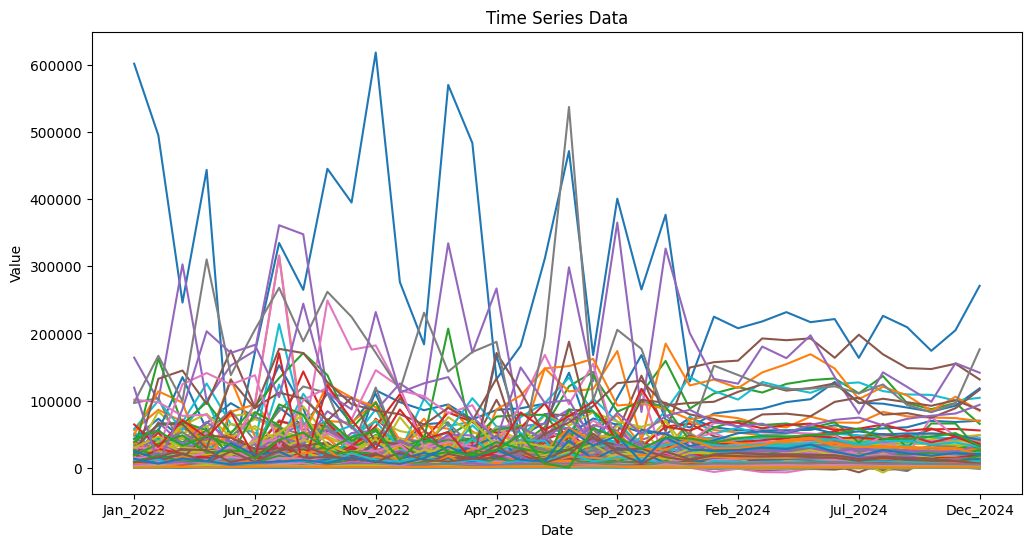

In [38]:
# Plot the time series
merged_df.transpose().plot(kind='line', figsize=(12, 6), legend=False)
plt.title('Time Series Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

# Model preentrenat

No furula

In [8]:
from neuralforecast.models import LSTM, NHITS, RNN, NBEATS

nf2 = NBEATS.load_from_checkpoint(checkpoint_path='./nbeats_m4.ckpt',h=12,input_size=12)
Y_hat_df = nf2.predict().reset_index()
Y_hat_df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'c:/Users/Usuario/Documents/Projectes/ChallengeAuditoria/challenge-auditoria/monthly_ts/nbeats_m4.ckpt'